<a href="https://colab.research.google.com/github/florencevivier/wikipedia-bigdata-article-classifier/blob/main/wikipedia_bigdata_classifier_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this project is to create a classification model to categorize the thematic domain of Wikipedia articles.

# Imports and dataset loading section

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.functions import udf, length, col, count, avg, min, max, round, concat_ws, sum as _sum, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, TrainValidationSplitModel
from pyspark.sql.types import DoubleType

In [ ]:
# The following setup block ensures that the environment is correctly configured for PySpark, which depends on Java to run.
!apt-get install openjdk-11-jdk -y
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin")

!pip install pyspark

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.28+6-1ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
# Creation of a Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SparkML").getOrCreate()

In [ ]:
# Dataset downloading
URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv"
!wget $URL -O /content/wikipedia.csv


--2025-11-10 10:15:41--  https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 3.5.206.249, 52.95.154.98
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|3.5.206.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003477941 (957M) [text/csv]
Saving to: ‘/content/wikipedia.csv’

/content/wikipedia. 100%[===================>] 956.99M  66.2MB/s    in 13s     

2025-11-10 10:15:55 (72.3 MB/s) - ‘/content/wikipedia.csv’ saved [1003477941/1003477941]



In [ ]:
# In order to import properly the data, the first 5 rows are visualized
with open("/content/wikipedia.csv", "r", encoding="utf-8") as f:
    for i in range(5):
        print(f.readline())

,title,summary,documents,categoria

0,economics,"economics () is a social science that studies the production, distribution, and consumption of goods and services.economics focuses on the behaviour and interactions of economic agents and how economies work. microeconomics analyzes what's viewed as basic elements in the economy, including individual agents and markets, their interactions, and the outcomes of interactions. individual agents may include, for example, households, firms, buyers, and sellers. macroeconomics analyzes the economy as a system where production, consumption, saving, and investment interact, and factors affecting it: employment of the resources of labour, capital, and land, currency inflation, economic growth, and public policies that have impact on these elements. other broad distinctions within economics include those between positive economics, describing ""what is"", and normative economics, advocating ""what ought to be""; between economic theory and applied 

The column separator is the comma, it is now possible to import the dataset and create the spark dataframe.

In [ ]:
# Creation of the dataframe and visualization of the first 5 rows
df = spark.read.csv("wikipedia.csv", header=True,sep=",", quote='"', escape='"')
df.show(5)

+---+--------------------+--------------------+--------------------+---------+
|_c0|               title|             summary|           documents|categoria|
+---+--------------------+--------------------+--------------------+---------+
|  0|           economics|economics () is a...|economics () is a...|economics|
|  1|index of economic...|this aims to be a...|this aims to be a...|economics|
|  2|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|
|  3|economic impact a...|an economic impac...|an economic impac...|economics|
|  4|      economic trend|economic trend ma...|economic trend ma...|economics|
+---+--------------------+--------------------+--------------------+---------+
only showing top 5 rows



# Exploratory Data Analysis

The objective of this first part is to deeply investigate the dataset content, and more precisely the characteristics of each class of articles.


## Dataset presentation

It is first important to know how big is the dataset.

In [ ]:
# Number of rows and columns in the df dataframe
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

Number of rows: 153232
Number of columns: 5


To understand which kind of information are at disposal, columns names are displayed.

In [ ]:
# Features names
features = df.columns
print(features)

['_c0', 'title', 'summary', 'documents', 'categoria']


So for each Wikipedia article, the following features are present: </br>
* 1st column: Number of identification, from 0
* 'title': Title of the article
* 'summary': Summary of the article
* 'documents': Article body
* 'categoria': Theme of the article: class for classification model to be built

Now, let's take a look to about 10 rows, casually taken from the dataframe, to better understand the contents.

In [ ]:
df.sample(False, 0.0001, seed=2).show()

+----+--------------------+--------------------+--------------------+---------+
| _c0|               title|             summary|           documents|categoria|
+----+--------------------+--------------------+--------------------+---------+
|6504|       tony mulhearn|anthony mulhearn ...|anthony mulhearn ...|economics|
|6592|          ken coates|kenneth sidney co...|kenneth sidney co...|economics|
|6697|      peter georgiou|panagiotis "peter...|panagiotis "peter...| politics|
|7965|pauline hanson's ...|pauline hanson's ...|pauline hanson's ...| politics|
|5462|       meitei chanu |meitei chanu (mei...|meitei chanu (mei...|  culture|
|9517|              tharon|thāron (meitei: t...|thāron (meitei: t...|  culture|
|2249|    roberto cavanagh|roberto lorenzo c...|roberto lorenzo c...|   sports|
|2900|        kishen singh|lieutenant colone...|lieutenant colone...|   sports|
|6745| maylandia callainos|maylandia callain...|maylandia callain...|     pets|
|9333|käpylä railway st...|käpylä (finni

## Dataset cleaning

Before analysing the dataset contents, it is important to clean it looking for eventual duplicates and missing values.

### Duplicates

Eventual duplicates are searched for looking at the column 'documents': in fact several articles with the same body text shouldn't coexist in the dataset.

In [ ]:
# Creation of a new dataframe with the duplicates only, and the number of rows sharing the same 'documents' content
duplicates = (df.groupBy("documents").agg(count("*").alias("count")).filter(col("count") > 1))

# Number of groups of duplicates
num_groups = duplicates.count()

# Visualization of the duplicates dataframe, and number of duplicates
duplicates.show(10)
print("Number of duplicates: ", num_groups)

+--------------------+-----+
|           documents|count|
+--------------------+-----+
|pawanexh kohli is...|    2|
|lawrence l. schka...|    3|
|william robert sp...|    2|
|narendra krishna ...|    2|
|alain krivine (fr...|    9|
|the movement for ...|    4|
|the international...|    3|
|socialist alterna...|    2|
|kenneth joseph ar...|    7|
|karl berngardovic...|    8|
+--------------------+-----+
only showing top 10 rows

Number of duplicates:  27695


This number of duplicates corresponds to the number of unique documents that appear more than once. It does not correspond to the number of rows to delete.

In [ ]:
# Sum of all articles with at least one duplicate
total_rows = duplicates.select(_sum(col("count")).alias('total')).collect()[0]["total"]

# Number of rows to delete to keep only one original article per group
to_remove = total_rows - num_groups

print("Number of articles to delete: ", to_remove)

Number of articles to delete:  79861


Now let's remove all of these 79 861 duplicates.

In [ ]:
#Removing of duplicates, based on the documents content
df = df.dropDuplicates(["documents"])

# Check of the absence of duplicates
duplicates_documents = (df.groupBy("documents").count().filter(col("count") > 1))
duplicates_documents.show(10)

+---------+-----+
|documents|count|
+---------+-----+
+---------+-----+



There is no duplicates anymore considering the article contents ('documents' column). </br>
Out of curiosity, we count how many titles are common to different articles. It is here considered they don't correspond to duplicates and can perfectly co-exist, as they may treat an argument under different aspects, or can be article's updates.

In [ ]:
# Count of articles with identical title
duplicates_title = (df.groupBy("title").count().filter(col("count") > 1))
result = duplicates_title.count()
print(f"Number of titles with duplicates: {result}")

Number of titles with duplicates: 483


### Missing data

In [ ]:
# Visualization of eventual row containing missing value
df.filter(sum(col(c).isNull().cast("int") for c in df.columns)>0).show(truncate=False)

+----+------------------------------------------+-------+---------+---------+
|_c0 |title                                     |summary|documents|categoria|
+----+------------------------------------------+-------+---------+---------+
|3518|file:sri kalamandalam padmanabhan nair.jpg|NULL   |NULL     |culture  |
+----+------------------------------------------+-------+---------+---------+



Only one article presents missing values in 'summary' and 'documents': it is better to remove it from the dataset.

In [ ]:
df = df.dropna()

In [ ]:
# Number of rows and columns in the df dataframe
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

Number of rows: 73370
Number of columns: 5


Final version of dataset after cleaning present 73 370 articles. </br>
Now the dataset is ready to calculate some statistics for each category.

## Statistics per category

As the aim here is to finally create a classification model, it is important to focus on the different existing categories, and their relative importance in the dataset (number of articles for each one).

In [ ]:
# To be able to use sql query, a temporary view is created
df.createOrReplaceTempView("articles")

# Creation of the 'category' dataframe
category = spark.sql("select distinct(categoria) from articles")

# Creation of a list containing the names of the different categories
category_list = [row["categoria"] for row in category.collect()]

print(f"Number of classes: {len(category_list)}")
print(f"List of the different classes: {category_list}")

List of the different classes: ['finance', 'medicine', 'research', 'technology', 'energy', 'transport', 'politics', 'culture', 'science', 'humanities', 'economics', 'trade', 'sports', 'pets', 'engineering']
Number of classes: 15


For each of these 15 categories, it is asked to: </br>
* count the number of articles
* calculate the average number of words per article
* length of both the longest and the shortest articles


### Count of number of articles

In [ ]:
# Creation of a new column in df containing the number of words in each article
df = df.withColumn("word_count", length(col("documents")))

# At this point, using groupBy on the categories it is possible to create
# a new dataframe containing the requested information
category_stats = df.groupBy("categoria").agg(
    count("*").alias("article_count"),
    round(avg("word_count")).cast("integer").alias("average_article_length"),
    min("word_count").alias("shortest_article_length"),
    max("word_count").alias("longest_article_length")).orderBy("article_count", ascending = False)

# Visualization of the new dataframe with statistics
category_stats.show()

+-----------+-------------+----------------------+-----------------------+----------------------+
|  categoria|article_count|average_article_length|shortest_article_length|longest_article_length|
+-----------+-------------+----------------------+-----------------------+----------------------+
|   medicine|         8202|                  4974|                     76|                119361|
|  transport|         7873|                  2821|                     57|                135535|
|   research|         6813|                  4454|                    116|                158762|
| technology|         6623|                  5367|                     29|                115154|
|engineering|         5996|                  4653|                     50|                 77579|
| humanities|         5755|                  5786|                     56|                135319|
|    finance|         5208|                  8169|                      7|                190204|
|       pets|       

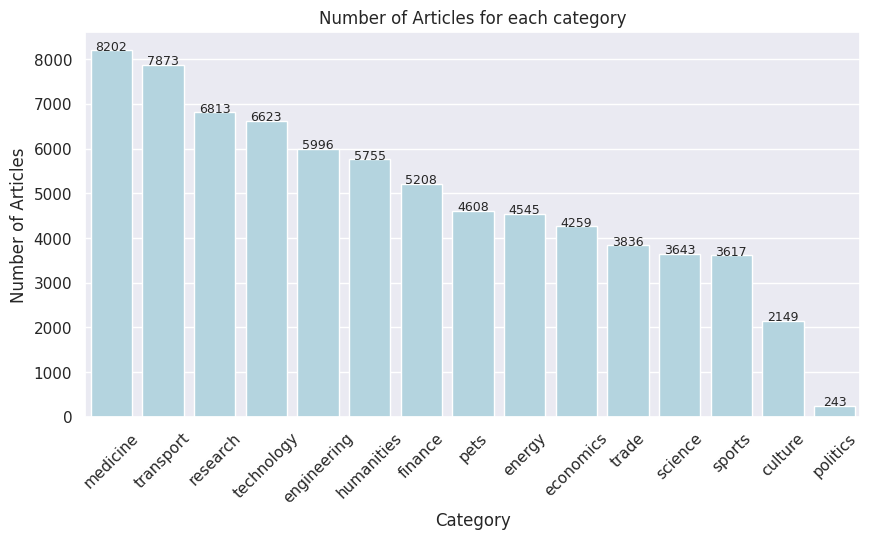

In [ ]:
# Conversion to pandas dataframe
category_stats_pd = category_stats.toPandas()

# Plot of the number of articles per category
sns.set(style="darkgrid")
plt.figure(figsize=(10,5))
ax = sns.barplot(x=category_stats_pd['categoria'], y='article_count', color ='lightblue', data=category_stats_pd)
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width() / 2, y=height + 0.5, s=f'{height:.0f}', ha='center', fontsize =9)
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.title("Number of Articles for each category")
plt.show()

The category with the most articles is 'medicine' with 8202
articles, and the one with less articles is 'politics' with 243 articles. </br>
These numbers evidenciate that the dataset is unbalanced between the 15 categories.

### Average number of words per article

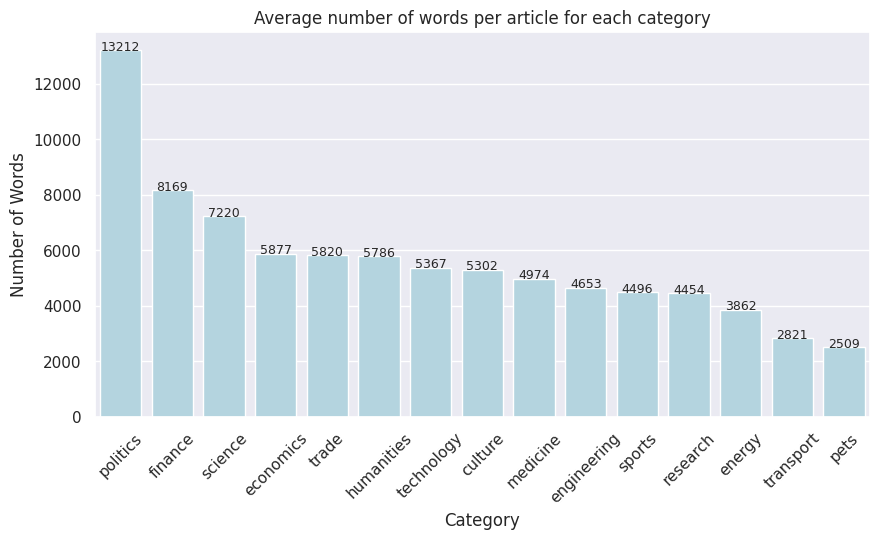

In [ ]:
# Order the dataframe by the value of average number of words,
# from the highest to the lowest values
df_sorted = category_stats_pd.sort_values(by='average_article_length', ascending=False)

# Plot of the statistic, by category
sns.set(style="darkgrid")
plt.figure(figsize=(10,5))
ax = sns.barplot(x=df_sorted['categoria'], y='average_article_length', color='lightblue', data=df_sorted)
for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width() / 2, y=height + 0.5, s=f'{height:.0f}', ha='center', fontsize =9)
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Number of Words")
plt.title("Average number of words per article for each category")
plt.show()

Considering the average length of the articles, there is a clear gap between the first category 'Politics' (with 13 212 words per article for this category), and the others. The category 'pets' presents the lower value with an average of 2 509 words per article.

### Length of the longest articles

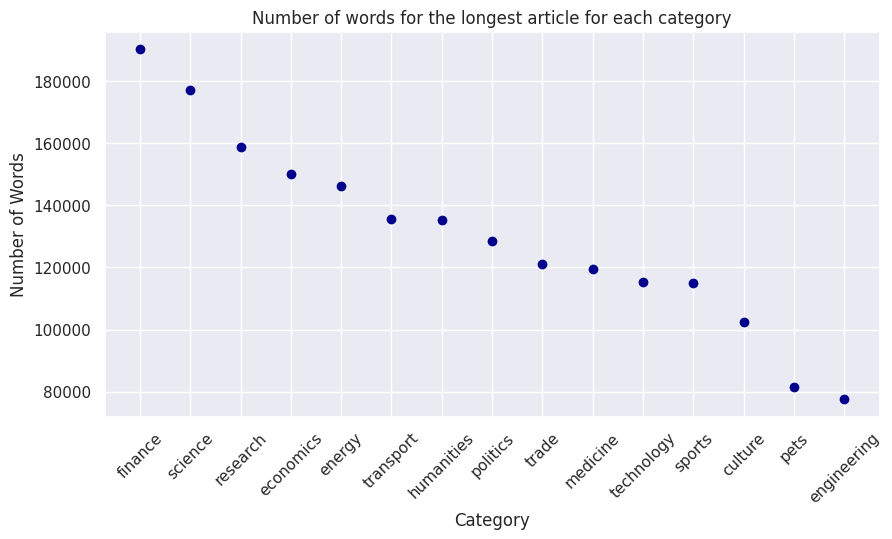

In [ ]:
# Order the dataframe by the value of length of the longest article,
# from the highest to the lowest values
df_sorted2 = category_stats_pd.sort_values(by='longest_article_length', ascending=False)

# Plot of the statistic, by category
sns.set(style="darkgrid")
plt.figure(figsize=(10,5))
plt.scatter(x=df_sorted2['categoria'], y=df_sorted2['longest_article_length'], color = 'darkblue')
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Number of Words")
plt.title("Number of words for the longest article for each category")
plt.show()

The categories presenting the longest articles with a length beyond 160 000 words are 'finance' and 'science'. While the categories with the longest articles below 100 000 words are 'pets' and 'engineering'.

### Length of the shortest articles

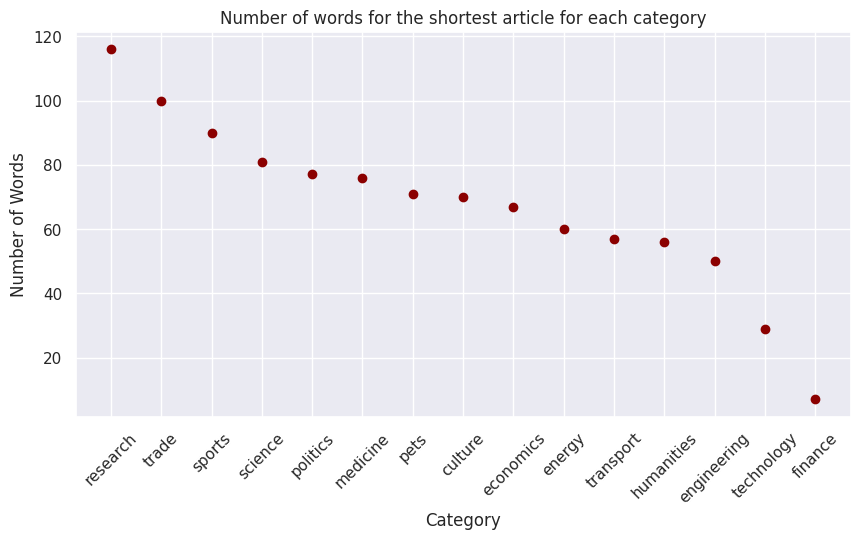

In [ ]:
# Order the dataframe by the value of length of the shortest article,
# from the highest to the lowest values
df_sorted2 = category_stats_pd.sort_values(by='shortest_article_length', ascending=False)

# Plot of the statistic, by category
sns.set(style="darkgrid")
plt.figure(figsize=(10,5))
plt.scatter(x=df_sorted2['categoria'], y=df_sorted2['shortest_article_length'], color = 'darkred')
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Number of Words")
plt.title("Number of words for the shortest article for each category")
plt.show()

The categories with shortest articles length beyond the 80 words are 'research', 'trade', 'sports' and 'science' ; while with the lowest numbers of words for the shortest articles there are the categories 'technology' and 'finance'.  

## Word clouds

Statistics have been calculated about the length (number of words) of articles per category. But what about their content? For each category a word cloud is created, in order to see at a glance the most popular terms.

In [ ]:
# Function able to create a word cloud for a given category
def word_cloud(category):
  # Creation of a dataframe filtered on the category
  df_filtered = df.filter(df.categoria==category)

  # Concatenation of all articles contents in one string
  unique_str = df_filtered.select(concat_ws(" ", col("documents"))).collect()[0][0]

  # Word cloud creation and visualization
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(unique_str)
  plt.figure(figsize=(14,7))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(f"-Word Cloud for {category}-", fontsize=18, color='black', loc='center')
  plt.tight_layout(pad=5)
  plt.show()

  # Print the 5 most frequent words
  # First order the words from highest to lowest frequency
  sorted_words = sorted(wordcloud.words_.items(), key=lambda x: x[1], reverse=True)
  # Visualize the top 5
  top5 = [item[0] for item in sorted_words[:5]]
  print(f"The 5 most common words in the category {category} are: {top5}")
  print("\n")

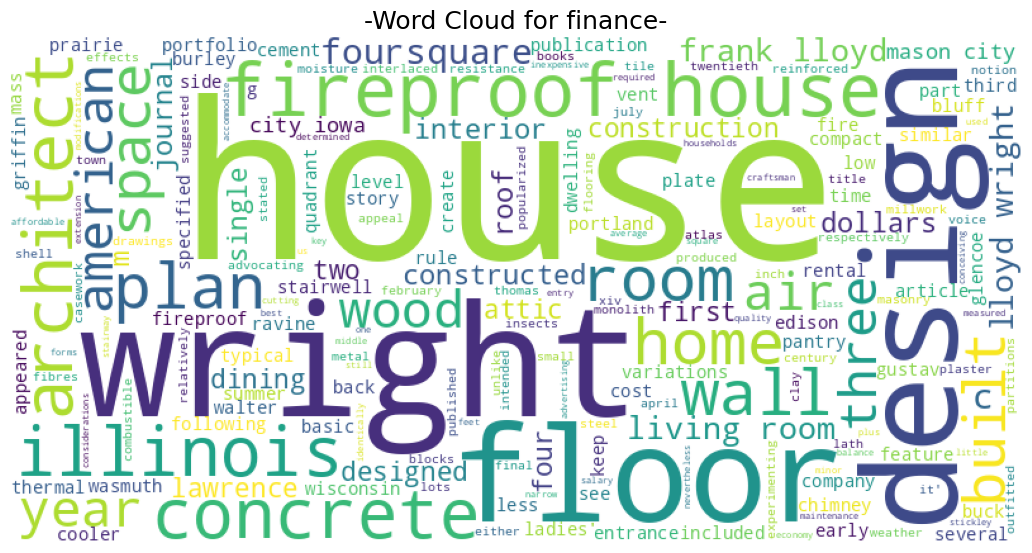

The 5 most common words in the category finance are: ['house', 'wright', 'design', 'floor', 'fireproof house']




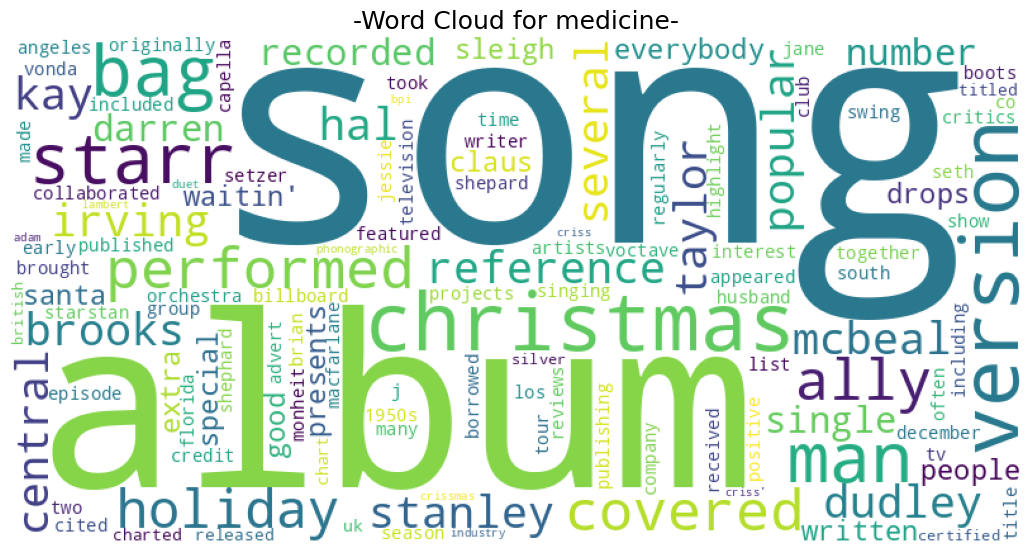

The 5 most common words in the category medicine are: ['song', 'album', 'christmas', 'version', 'man']




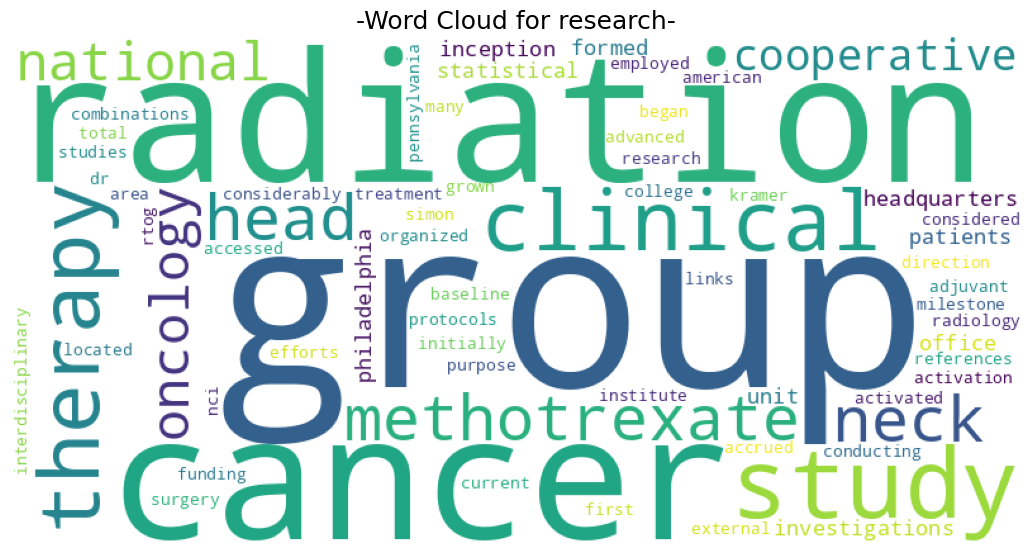

The 5 most common words in the category research are: ['group', 'radiation', 'cancer', 'study', 'therapy']




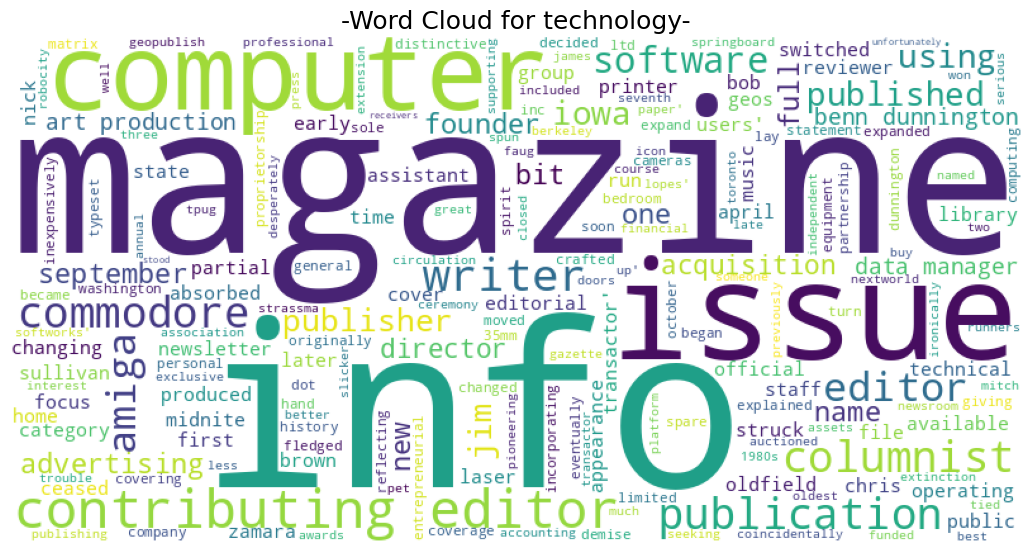

The 5 most common words in the category technology are: ['info', 'magazine', 'issue', 'computer', 'contributing editor']




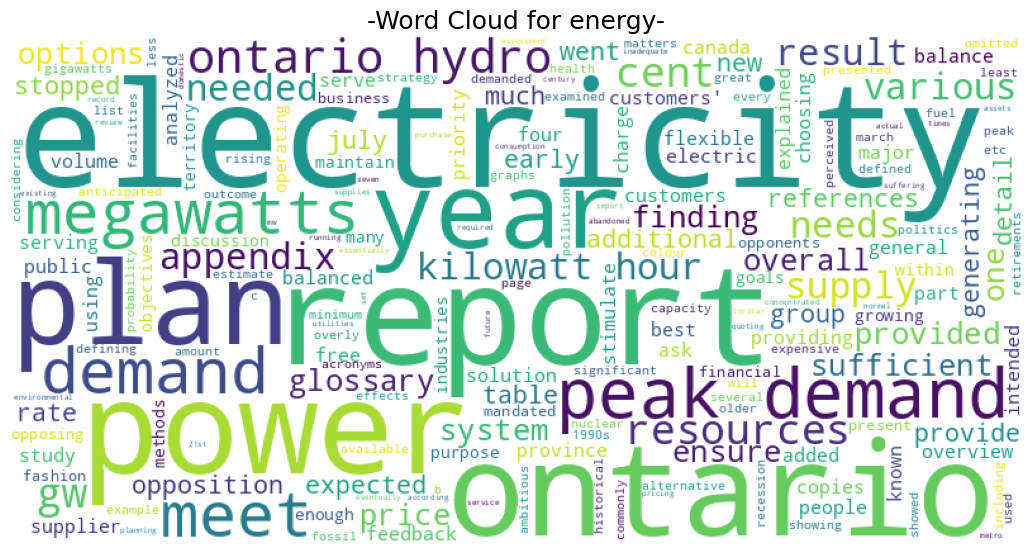

The 5 most common words in the category energy are: ['electricity', 'report', 'power', 'ontario', 'plan']




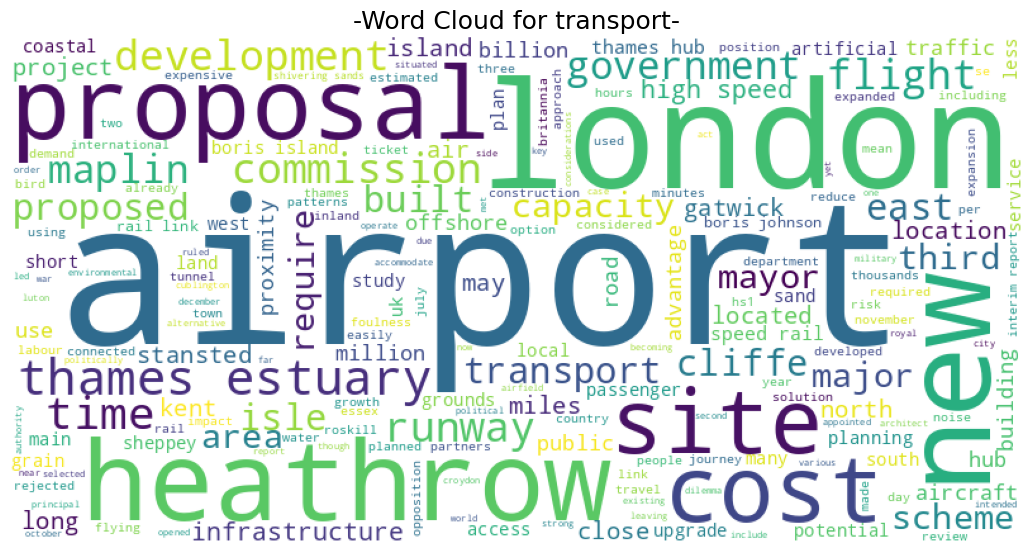

The 5 most common words in the category transport are: ['airport', 'london', 'new', 'heathrow', 'proposal']




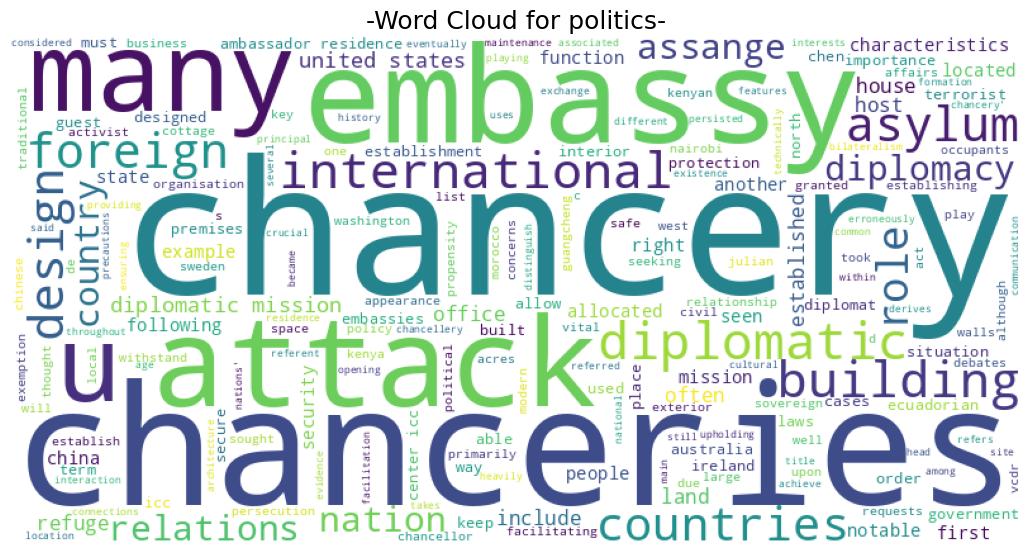

The 5 most common words in the category politics are: ['chancery', 'chanceries', 'embassy', 'attack', 'many']




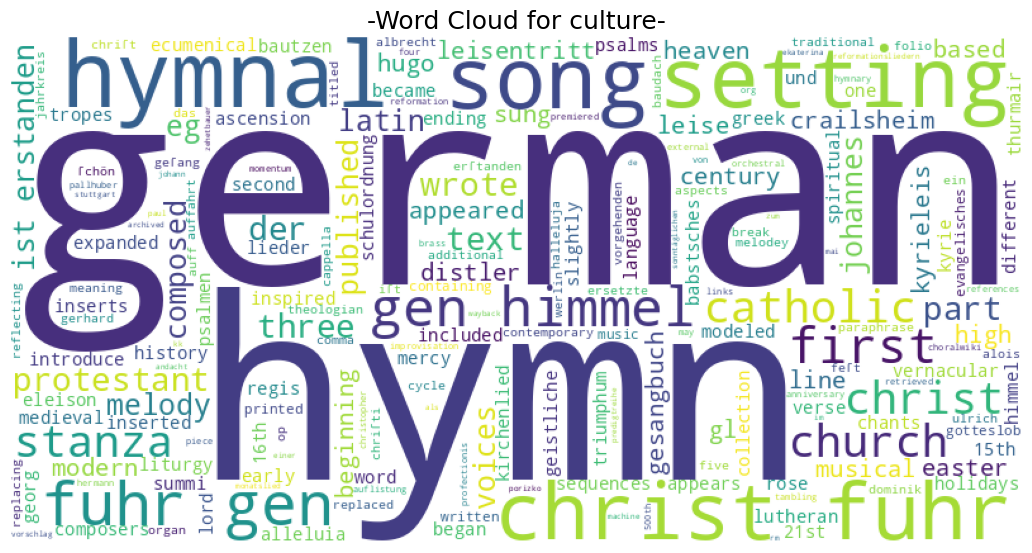

The 5 most common words in the category culture are: ['german', 'hymn', 'hymnal', 'song', 'setting']




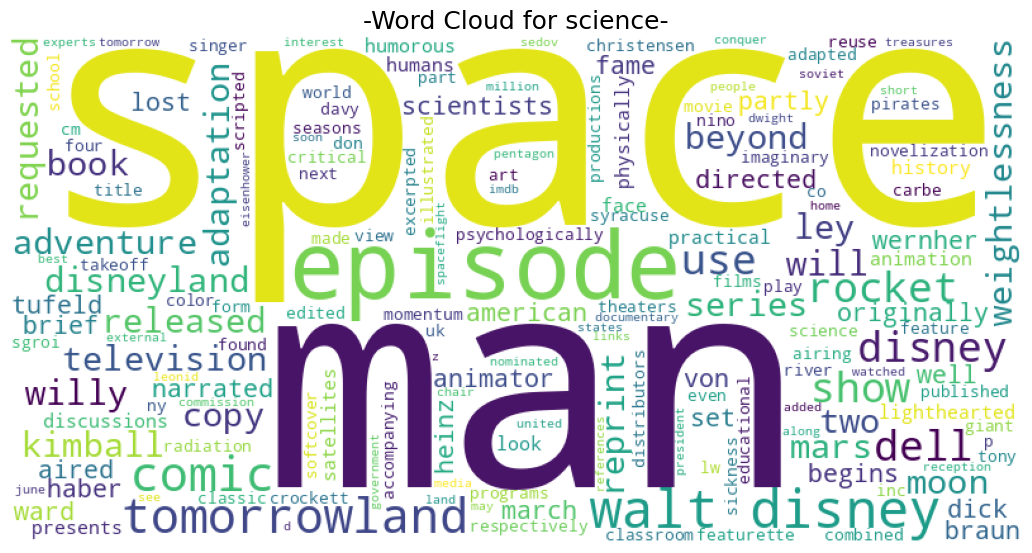

The 5 most common words in the category science are: ['space', 'man', 'episode', 'walt disney', 'tomorrowland']




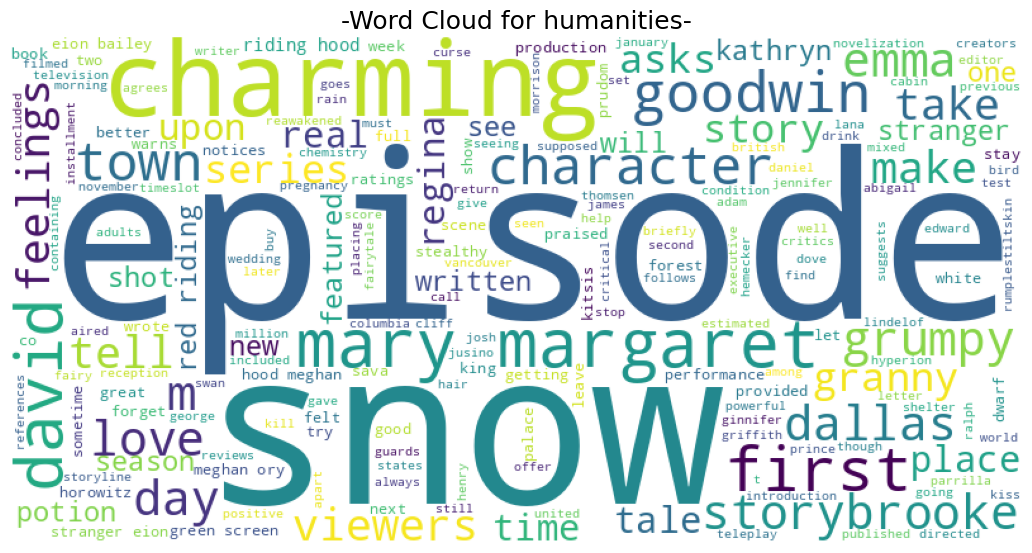

The 5 most common words in the category humanities are: ['episode', 'snow', 'charming', 'mary margaret', 'david']




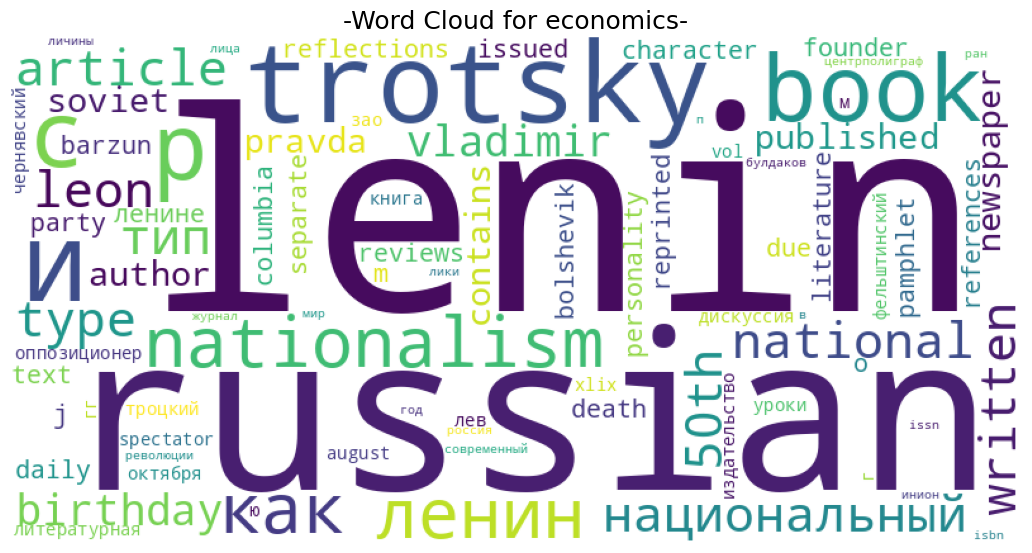

The 5 most common words in the category economics are: ['lenin', 'russian', 'trotsky', 'и', 'book']




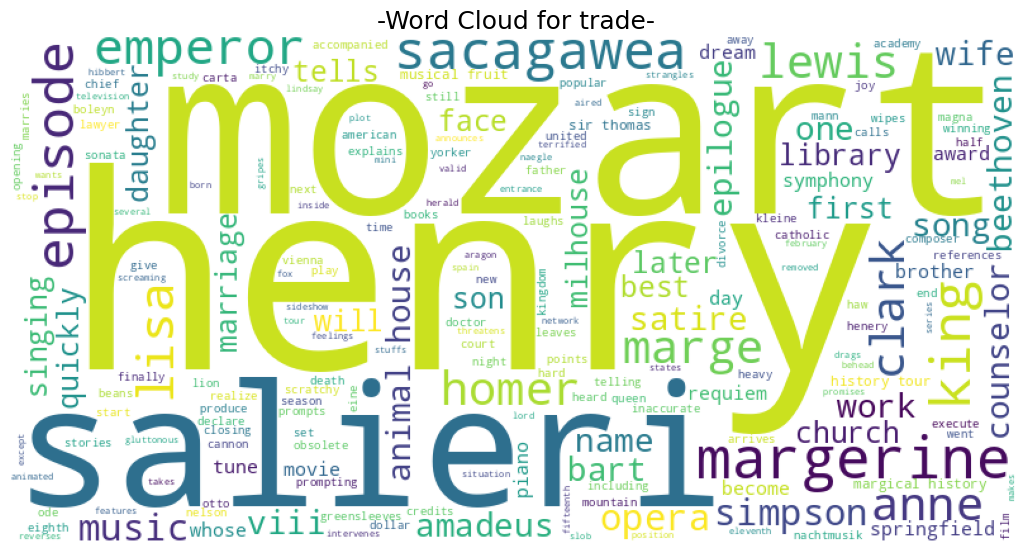

The 5 most common words in the category trade are: ['henry', 'mozart', 'salieri', 'margerine', 'episode']




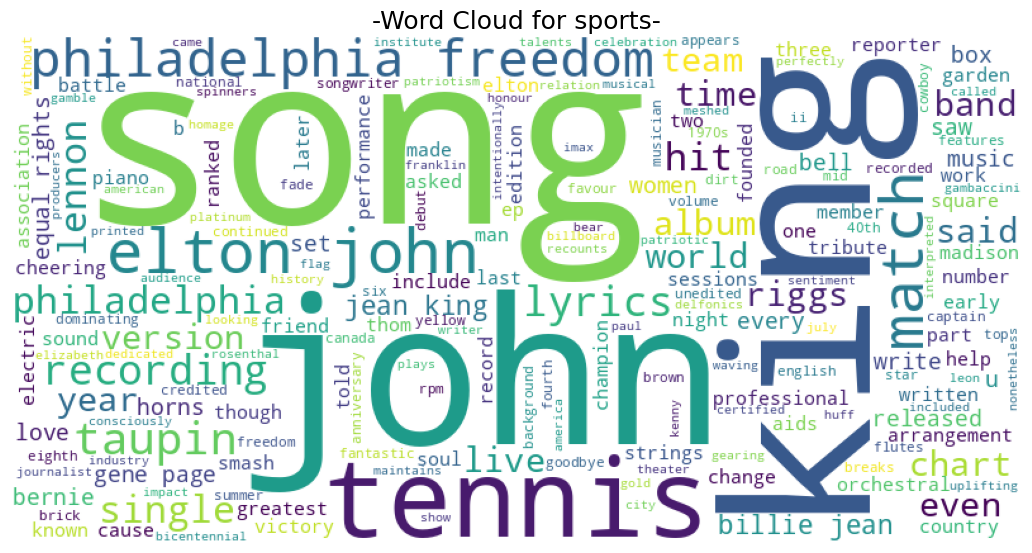

The 5 most common words in the category sports are: ['song', 'john', 'king', 'tennis', 'elton john']




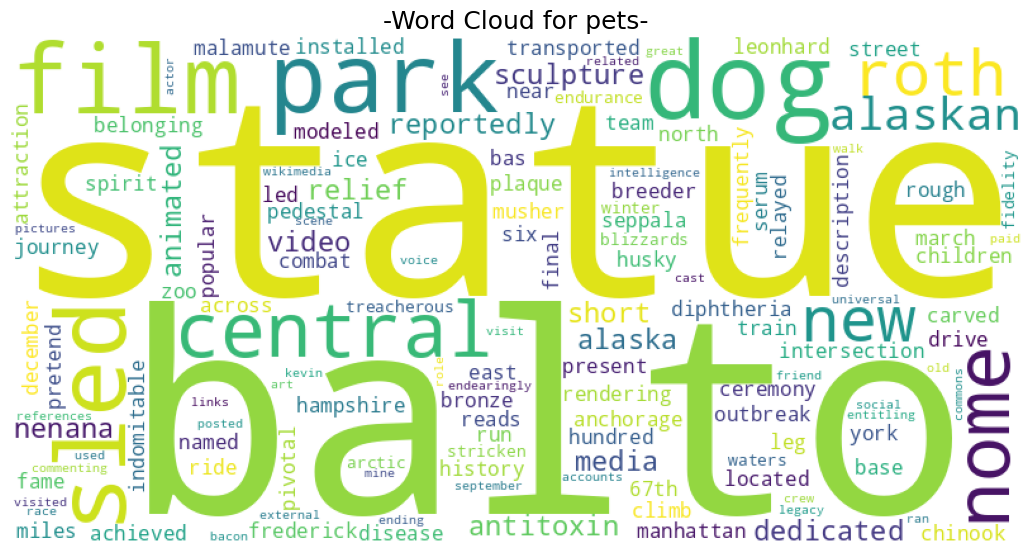

The 5 most common words in the category pets are: ['statue', 'balto', 'dog', 'park', 'sled']




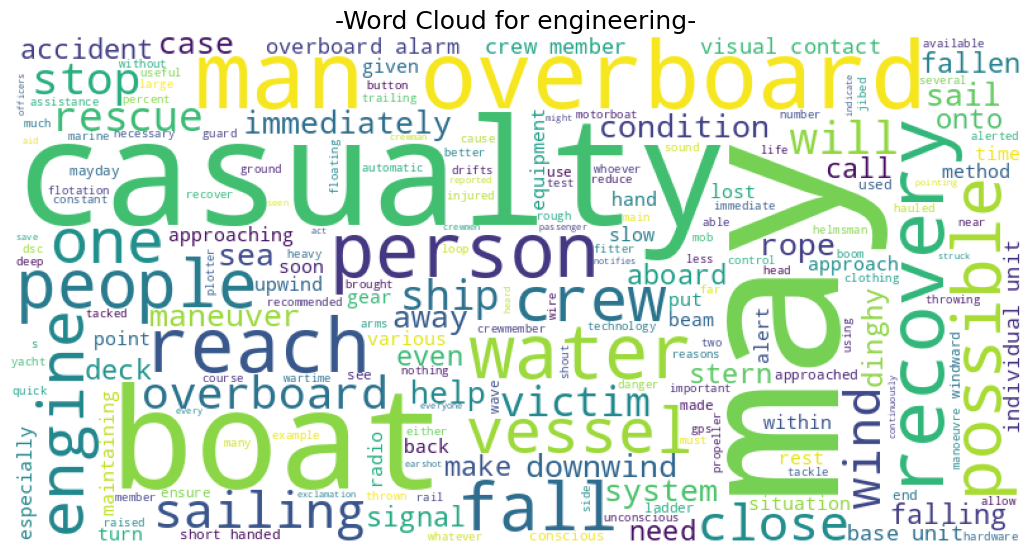

The 5 most common words in the category engineering are: ['may', 'casualty', 'boat', 'man overboard', 'recovery']




In [ ]:
# Creation of the word clouds for the 15 categories
for cat in category_list:
  word_cloud(cat)

Taking a look to for example the "science" category word cloud, it could be surprising to see that the most frequent terms are ['space', 'man', 'episode', 'walt disney', 'tomorrowland']. </br>
It is interesting to show some of the title and summary of these articles.

In [ ]:
science_articles = spark.sql("select _c0, title, summary, categoria from articles where categoria = 'science'")
science_articles.show(10, truncate = False)

+-----+-------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

On these 10 articles categorized as scientific, two of them are related to science-fiction movie or episode. The fact that science-fiction is classified in 'science' category partly explains the word cloud results.

Looking at the 'trade' category word cloud, the most frequent words appeared to be: ['henry', 'mozart', 'salieri', 'margerine', 'episode']. It can seem a bit suprising as well, so some of the articles belonging to the this category containing 'Mozart' name are shown.

In [ ]:
trade_articles = spark.sql("""
    SELECT _c0, title, documents, categoria
    FROM articles
    WHERE lower(documents) LIKE '%mozart%'
      AND categoria = 'trade' """)

trade_articles.show(3, truncate = False)

+----+---------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Analysis: </br>
* 1st article : story of an episode of the serie 'The Simpsons' where one of the main characters (Bart Simpson) interpretes the famous composer. </br>
* 2nd article: Mozart is mentioned for his masterpiece 'The Marriage of Figaro' </br>
* 3rd article: the article is about a famous american conductor </br>
It seems that Wikipedia consolidates topics in “trade” section to show examples of professionals working in media, entertainment, or arts. Mozart being a very famous artist, his name is found frequently in the 'trade' articles.

# Preprocessing

First, two functions should be applied to the text in order to preprocess it for next steps: they perform lowercasing and remove numbers and special characters. </br>
Different models will be tested, with the 'documents' column or the 'summary' one as inputs for classification task: both are preprocessed.

In [ ]:
# Proceed to lowercasing for 'documents' and 'summary' :
# New columns created 'documents_lower' and 'summary_lower'
df = (df.withColumn("documents_lower", lower(col("documents")))
      .withColumn("summary_lower", lower(col("summary"))))

# Remove all numbers and special characters
# Everything different from a letter or a space is replace by an empty string
# New columns created: 'documents_clean' and 'summary_clean'
df = (df.withColumn("documents_clean", regexp_replace(col("documents_lower"), "[^a-zA-Z\\s]", ""))
      .withColumn("summary_clean", regexp_replace(col("summary_lower"), "[^a-zA-Z\\s]", "")))

In [ ]:
# Visualization of the dataframe with the new columns
df.show(5)

+----+--------------------+--------------------+--------------------+----------+----------+--------------------+--------------------+--------------------+--------------------+
| _c0|               title|             summary|           documents| categoria|word_count|     documents_lower|       summary_lower|     documents_clean|       summary_clean|
+----+--------------------+--------------------+--------------------+----------+----------+--------------------+--------------------+--------------------+--------------------+
|9534| the man with the...|"(everybody's wai...|"(everybody's wai...|  medicine|      1842|"(everybody's wai...|"(everybody's wai...|everybodys waitin...|everybodys waitin...|
|8710|           7:15 a.m.|"7:15 a.m." is th...|"7:15 a.m." is th...|humanities|     11387|"7:15 a.m." is th...|"7:15 a.m." is th...| am is the tenth ...| am is the tenth ...|
|8758|    a curious thing |"a curious thing"...|"a curious thing"...|humanities|     11004|"a curious thing"...|"a curio

Then, the dataframe is divided into train and test sets.

In [ ]:
df_train, df_test = df.randomSplit([0.8, 0.2], seed =0)

# Models creation

## Logistic Regression Model

### Basic Model


For a first trial, a Logistic Regression model is considered.

In [ ]:
# Tokenization: each text is divided in single words
# Input: 'documents', corresponding to the body of text of the article
tokenizer_doc = Tokenizer(inputCol="documents_clean", outputCol="tokens")

# Remove stop words
remover = StopWordsRemover(inputCol="tokens", outputCol="tokens_clean")

# Text vectorization: words must be converted into numbers to be ready for ML modellization
cv = CountVectorizer(inputCol="tokens_clean", outputCol="raw_features", vocabSize=4000)

# Standardization of the created vector
scaler = StandardScaler(inputCol = "raw_features", outputCol = "features")

# Convert the classes from strings to numbers
indexer = StringIndexer(inputCol="categoria", outputCol="label_num")

In [ ]:
# Classification model: LogisticRegression for multiclass model
lr = LogisticRegression(featuresCol="features", labelCol="label_num", family="multinomial")

In [ ]:
# Pipeline instance
pipeline_lr_docs = Pipeline(stages = [tokenizer_doc, remover, cv, scaler, indexer, lr])

# Pipeline fitting
model_lr_docs = pipeline_lr_docs.fit(df_train)

In [ ]:
# Saving the fitted model
# model_lr_docs.save("/content/drive/MyDrive/model_lr_docs")

# Loading the fitted model
# model_lr_docs = PipelineModel.load("/content/drive/MyDrive/model_lr_docs")

Considering the unbalanced dataset, accuracy is not the best parameter to appreciate the model quality, F1 is prefered.

In [ ]:
# Evaluator to appreciate the model performances, using Weighted F1
evaluator = MulticlassClassificationEvaluator(labelCol="label_num",
    predictionCol="prediction", metricName="f1")

In [ ]:
# Functions to do predictions and to evaluate performances on both train and test sets
def get_predictions(model, df_train, df_test):
  train_pred = model.transform(df_train)
  test_pred = model.transform(df_test)
  return train_pred, test_pred

def get_evaluation(evaluator, train_pred, test_pred):
  train_f1 = evaluator.evaluate(train_pred)
  test_f1 = evaluator.evaluate(test_pred)
  print(f"Weighted F1 on train set for this model: {train_f1:.2f}")
  print(f"Weighted F1 on test set for this model: {test_f1:.2f}")

Predictions on train and test sets ; </br>
model evaluation through F1 score calculation.

In [ ]:
train_pred, test_pred = get_predictions (model_lr_docs, df_train, df_test)
get_evaluation(evaluator, train_pred, test_pred )

Weighted F1 on train set for this model: 0.99
Weighted F1 on test set for this model: 0.84


Accuracies values here of 99% on train set and 84% on test set evidenciate the model perform quite well, but there is overfitting.

### Model with weights classes parameter and L2 regularization

For Logistic Regression models, it is possible to give to the predictive model the weights to consider for each class when the dataset is unbalanced. </br>
To calculate weights, it is necessary to first create the label column with numerical value (it corresponds to the StringIndexer transformation which converts the classes from strings to numbers).

In [ ]:
# Instance of String Indexer
indexer = StringIndexer(inputCol="categoria", outputCol="label_num")

# Fit the indexer on the training data and transform both train and test data
indexer_model = indexer.fit(df_train)
df_train_w = indexer_model.transform(df_train)
df_test_w = indexer_model.transform(df_test)

In [ ]:
# Creation of the weights, inversely proportional to the frequency
total_count = df_train_w.count()
class_counts = df_train_w.groupBy("label_num").count().collect()
class_weights = {row['label_num']: total_count/row['count'] for row in class_counts}

# Define a UDF to get the weight based on label_num
get_weight_udf = udf(lambda label_num_val: class_weights.get(label_num_val, 1.0), DoubleType())

# Add the 'weight' column to the train set dataframe using the UDF
df_train_w = df_train_w.withColumn("weight", get_weight_udf(col("label_num")))

In [ ]:
# Insertion of weights as parameter for logistic regression model istance and L2 regularization to improve overfitting
lr_weight_reg = LogisticRegression(featuresCol="features", labelCol="label_num", weightCol="weight", regParam=0.1, family="multinomial")

The predictive model istance has been changed. Now as done before, it will be put in the pipeline, model fitting will be done on train dataframe, and both train and test dataset will be transformed to finally calculate F1 metrics and compare this model with the basic logistic regression one.

In [ ]:
# Pipeline creation
model_lr_docs_w_reg = Pipeline(stages = [tokenizer_doc, remover, cv, scaler, lr_weight_reg])
model_lr_docs_w_reg = pipeline_lr_docs_w_reg.fit(df_train_w)

# Saving the fitted model
# model_lr_docs_w_reg.save("/content/drive/MyDrive/model_lr_docs_w_reg")

# Loading the fitted model
# model_lr_docs_w_reg = PipelineModel.load("/content/drive/MyDrive/model_lr_docs_w_reg")

# Predictions and evaluation for both train and test sets (overwritting on train_pred and test_pred)
train_pred, test_pred = get_predictions (model_lr_docs_w_reg, df_train_w, df_test_w)
get_evaluation(evaluator, train_pred, test_pred)

Weighted F1 on train set for this model: 0.86
Weighted F1 on test set for this model: 0.83


F1 values are equal to of 86% and 83% for respectively train and test sets ; as F1 values difference is minor to 5%, it can be considered that there is not overfitting anymore, and these are good performances that allow to say the model generalizes well.

## Naive Bayes Model

For Naive Bayes model there is no weigthCol parameter to especially deal with unbalanced dataset. </br>
The scaling step is removed, as the model interprets the feature values as counts.

In [ ]:
tokenizer_doc = Tokenizer(inputCol="documents_clean", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="tokens_clean")
cv = CountVectorizer(inputCol="tokens_clean", outputCol="features", vocabSize=4000)
indexer = StringIndexer(inputCol="categoria", outputCol="label_num")

# Model instance
nb = NaiveBayes(featuresCol="features", labelCol="label_num")

# Pipeline with 'documents' as input
pipeline_nb_docs = Pipeline(stages=[tokenizer_doc, remover, cv, indexer, nb])

In [ ]:
# Fitting of the model, still considering the 'documents' column
model_nb_docs = pipeline_nb_docs.fit(df_train)

In [ ]:
# Saving the fitted model
# model_nb_docs.write().overwrite().save("/content/drive/MyDrive/model_nb_docs")

# Loading the fitted model
# model_nb_docs = PipelineModel.load("/content/drive/MyDrive/model_nb_docs")

# Predictions and evaluation for both train and test sets (overwritting on train_pred and test_pred)
train_pred, test_pred = get_predictions (model_nb_docs, df_train, df_test)
get_evaluation(evaluator, train_pred, test_pred)

Weighted F1 on train set for this model: 0.79
Weighted F1 on test set for this model: 0.78


F1 values of 79% and 78% for train and test sets show good performances and no overfitting, but previous logistic regression model is still prefered.

## Random Forest Model

The last classification model to test in this study is the random forest classifier. </br>
As for logistic regression model, it is possible to give weightCol as parameter, to treat the unbalanced classes issue. </br>
The number of trees is taken equal to 50, to have a good balance between accuracy and execution speed. </br>
The maximum depth of trees is put at 10, which is a good bias between complexity and dataset understanding. </br>
The subsampling rate corresponds to the part of train set considered to build each tree. As it introduces randomization, it should decrease overfitting risk. </br>
At each split in the decision tree, only some of the features are considered (a value equal to the square root of the features numbers) ; it should lead to a best generalization ability.

In [ ]:
tokenizer_doc = Tokenizer(inputCol="documents_clean", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="tokens_clean")
cv = CountVectorizer(inputCol="tokens_clean", outputCol="raw_features", vocabSize=4000)
scaler = StandardScaler(inputCol = "raw_features", outputCol = "features")
indexer = StringIndexer(inputCol="categoria", outputCol="label_num")

# Model instance:
rf = RandomForestClassifier(featuresCol="features", labelCol="label_num", numTrees=50,
    maxDepth=7, subsamplingRate=0.8, featureSubsetStrategy="sqrt", weightCol="weight", seed=0)

In [ ]:
# Pipeline with 'documents' as input
pipeline_rf_docs = Pipeline(stages = [tokenizer_doc, remover, cv, scaler, rf])

In [ ]:
# Fitting of the model
model_rf_docs = pipeline_rf_docs.fit(df_train_w)

# Saving the fitted model
# model_rf_docs.save("/content/drive/MyDrive/model_rf_docs")

# Loading the fitted model
# model_rf_docs = PipelineModel.load("/content/drive/MyDrive/model_rf_docs")

# Predictions and evaluation for both train and test sets (overwritting on train_pred and test_pred)
train_pred, test_pred = get_predictions (model_rf_docs, df_train_w, df_test_w)
get_evaluation(evaluator, train_pred, test_pred)

Weighted F1 on train set for this model: 0.68
Weighted F1 on test set for this model: 0.68


As the F1 values for train and test sets are both equal to 68%, this is not the best model tested so far.

## Best Model

It appeared that the best F1 values found without overfitting have been obtained for the Logistic Regression with weights classes and regularization L2. </br>
It is interesting to see how would perform the model fitted on summary data, and not on the entire article body text. </br>

In [ ]:
tokenizer_sum = Tokenizer(inputCol="summary_clean", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="tokens_clean")
cv = CountVectorizer(inputCol="tokens_clean", outputCol="raw_features", vocabSize=4000)
scaler = StandardScaler(inputCol = "raw_features", outputCol = "features")
indexer = StringIndexer(inputCol="categoria", outputCol="label_num")
lr_weight_reg_sum = LogisticRegression(featuresCol="features", labelCol="label_num", weightCol="weight", regParam=0.1, family="multinomial")

In [ ]:
# Pipeline creation
pipeline_lr_sum_w_reg = Pipeline(stages = [tokenizer_sum, remover, cv, scaler, lr_weight_reg_sum])
model_lr_sum_w_reg = pipeline_lr_sum_w_reg.fit(df_train_w)

# Saving the fitted model
# model_lr_sum_w_reg.save("/content/drive/MyDrive/model_lr_sum_w_reg")

# Loading the fitted model
# model_lr_sum_w_reg = PipelineModel.load("/content/drive/MyDrive/model_lr_sum_w_reg")

# Predictions and evaluation for both train and test sets (overwritting on train_pred and test_pred)
train_pred, test_pred = get_predictions (model_lr_sum_w_reg, df_train_w, df_test_w)
get_evaluation(evaluator, train_pred, test_pred)

Weighted F1 on train set for this model: 0.89
Weighted F1 on test set for this model: 0.85


The F1 values obtained here are very similar to the ones from model fitted on the entire text body of the articles. Considering the gain from a computational cost perspective, this model is the one prefered.

It is important to check in details the results obtained by the model, considering the classification class by class.

In [ ]:
# Considering from test_pred only prediction and label_num columns.
# Transform for each row these data in tuples.
predictionAndLabels = test_pred.select("prediction", "label_num").rdd.map(tuple)

# Instance of MulticlassMetrics object
metrics = MulticlassMetrics(predictionAndLabels)

# List of the numerical ordered labels
labels = sorted(predictionAndLabels.map(lambda x: x[1]).distinct().collect())

# Obtain the list of original names of classes from StringIndexer
original_labels = indexer_model.labels

# For each category, different metrics are calculated
for label in labels:
    label_name = original_labels[int(label)]
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1 = metrics.fMeasure(label)

    print(f"Classe '{label_name}':")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall:    {recall:.2f}")
    print(f"  F1-score:  {f1:.2f}")
    print()

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Classe 'medicine':
  Precision: 0.83
  Recall:    0.70
  F1-score:  0.76

Classe 'transport':
  Precision: 0.96
  Recall:    0.92
  F1-score:  0.94

Classe 'research':
  Precision: 0.76
  Recall:    0.80
  F1-score:  0.78

Classe 'technology':
  Precision: 0.94
  Recall:    0.90
  F1-score:  0.92

Classe 'engineering':
  Precision: 0.78
  Recall:    0.84
  F1-score:  0.81

Classe 'humanities':
  Precision: 0.90
  Recall:    0.87
  F1-score:  0.88

Classe 'finance':
  Precision: 0.79
  Recall:    0.82
  F1-score:  0.80

Classe 'pets':
  Precision: 0.94
  Recall:    0.94
  F1-score:  0.94

Classe 'energy':
  Precision: 0.95
  Recall:    0.88
  F1-score:  0.91

Classe 'economics':
  Precision: 0.83
  Recall:    0.92
  F1-score:  0.87

Classe 'trade':
  Precision: 0.83
  Recall:    0.85
  F1-score:  0.84

Classe 'science':
  Precision: 0.77
  Recall:    0.80
  F1-score:  0.79

Classe 'sports':
  Precision: 0.92
  Recall:    0.90
  F1-score:  0.91

Classe 'culture':
  Precision: 0.71
  Reca

Generally, metrics for all classes are high and similar. 'Politics' category needs special attention, as it is the underrepresented class. </br>
In fact its metrics are low: </br>
* only 36% of the 'politics' labeled articles really belong to this category: there are lots of false positive cases.
* 69% of the real political articles are labeled as such, which is a quite good result.
* a 48% of harmonic mean is low, but not catastrophic.

# Conclusion

The EDA part started with the removal of more than 50% of the dataset due to duplicates. </br>
The dataset is unbalanced, as numbers of articles per category varies from 243 to 8202. </br>
The average length of articles varies also significantly: from 2509 words for the 'pets' category to 13 212 words for the 'politics' one.</br>

Due to computational limitations, hyperparameters tuning has not been done, and it prevents the model to perform as its best. </br>

The models tested in this study are the following:
* Logistic Regression as basic model
* Logistic Regression with weight classes and L2 regularization
* Naive Bayes
* Random Forest </br>

The best performances (F1 values without sign of overfitting) correspond to the Logistic Regression with weight classes and L2 regularization. </br>
On the last part of this study, a similar model is created considering summary data instead of documents. It showed similar metrics with an important gain in terms of computational cost : it corresponds to the prefered model in this study. </br>
Finally, a special attention is dedicated to the detailed metrics for each class (important due to unbalanced dataset), showing low performances only for the underrepresented class 'politics', as expected. </br>



